# Where to start a yoga studio? Segmenting and clustering of neighborhoods in Calgary, Alberta (Canada)

Final assignment Capstone Coursera, as a part of the IBM Data Science Professional Certificate course

 Femke Janssen, 31-01-2021

## Getting the dataset from Wikipedia

In [1]:
#First, import packages
import pandas as pd
from bs4 import BeautifulSoup
import requests
import numpy as np
#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from pandas.io.json import json_normalize  # tranform JSON file into a pandas dataframe

#!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

# import k-means from clustering stage
from sklearn.cluster import KMeans

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

### Scrape the data 

In [2]:
# get the response in the form of html
wikiurl="https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_T"
table_class="wikitable sortable jquery-tablesorter"
response=requests.get(wikiurl)
print(response.status_code)
#if output = 200, then it is fine!

200


In [3]:
# parse data from the html into a beautifulsoup object
soup = BeautifulSoup(response.text, 'html.parser')
toronto_table=soup.find('table',{'class':"wikitable"})

In [4]:
df=pd.read_html(str(toronto_table))
# convert list to dataframe
df=pd.DataFrame(df[0])
df.head(15)

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,T1A,Medicine Hat,Central Medicine Hat,50.036460,-110.679250
1,T2A,Calgary,"Penbrooke Meadows, Marlborough",51.049680,-113.964320
2,T3A,Calgary,"Dalhousie, Edgemont, Hamptons, Hidden Valley",51.126060,-114.143158
3,T4A,Airdrie,East Airdrie,51.272450,-113.986980
4,T5A,Edmonton,"West Clareview, East Londonderry",53.5899,-113.4413
5,T6A,Edmonton,North Capilano,53.5483,-113.408
6,T7A,Drayton Valley,Not assigned,53.2165,-114.9893
7,T8A,Sherwood Park,West Sherwood Park,53.519,-113.3216
8,T9A,Wetaskiwin,Not assigned,52.9741,-113.3646
9,T1B,Medicine Hat,South Medicine Hat,50.0172,-110.651


## Process the data

In [5]:
#Only process the cells that have an assigned borough. Ignore cells with a borough that is Not assigned.
alberta_dropNotAssigned = df[df.Borough != 'Not assigned'].reset_index(drop=True)

In [6]:
#More than one neighborhood can exist in one postal code area. 
# These rows will be combined into one row with the neighborhoods separated with a comma.
alberta_grouped = alberta_dropNotAssigned.groupby(['Postal Code','Borough'], as_index=False).agg(lambda x: ','.join(x))

In [7]:
#If a cell has a borough but a Not assigned  neighborhood, then the neighborhood will be the same as the borough.
mask = alberta_grouped['Neighborhood'] == "Not assigned"
alberta_grouped.loc[mask, 'Neighborhood'] = alberta_grouped.loc[mask, 'Borough']

In [8]:
#The dataset now looks like this:
alberta_grouped.head(10)

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,T1A,Medicine Hat,Central Medicine Hat,50.036460,-110.679250
1,T1B,Medicine Hat,South Medicine Hat,50.0172,-110.651
2,T1C,Medicine Hat,North Medicine Hat,50.0556,-110.6822
3,T1G,Taber,Taber,49.7773,-112.158
4,T1H,Lethbridge,North Lethbridge,49.7118,-112.8196
5,T1J,Lethbridge,West and Central Lethbridge,49.6915,-112.8294
6,T1K,Lethbridge,West and South Lethbridge,49.6765,-112.8035
7,T1L,Banff,Banff,51.1791,-115.5697
8,T1M,Coaldale,Coaldale,49.7285,-112.6146
9,T1P,Strathmore,Strathmore,51.0459,-113.3967


In [9]:
alberta_grouped.shape

(144, 5)

## Cluster the neighbourhoods in Calgary, Alberta

Get latitude and longitude of Calgary:

In [10]:
address = "Calgary, AB"

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Calgary are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Calgary are 51.0534234, -114.0625892.


Make a map of Calgary with Folium:

In [11]:
map_calgary = folium.Map(location=[latitude, longitude], zoom_start=10)
map_calgary

Check the dataframe to see whether the latitude and longitude columns all have values instead of missing values:

In [12]:
df

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,T1A,Medicine Hat,Central Medicine Hat,50.036460,-110.679250
1,T2A,Calgary,"Penbrooke Meadows, Marlborough",51.049680,-113.964320
2,T3A,Calgary,"Dalhousie, Edgemont, Hamptons, Hidden Valley",51.126060,-114.143158
3,T4A,Airdrie,East Airdrie,51.272450,-113.986980
4,T5A,Edmonton,"West Clareview, East Londonderry",53.5899,-113.4413
...,...,...,...,...,...
175,T5Z,Edmonton,West Lake District,53.5966,-113.4882
176,T6Z,Not assigned,Not assigned,Not assigned,Not assigned
177,T7Z,Stony Plain,Not assigned,53.5202,-114.0135
178,T8Z,Not assigned,Not assigned,Not assigned,Not assigned


As can be seen, there are still values that are not assigned (even though we did pre-processing, I missed these) , so I'm gonna delete the rows for which Latitude and Longitude have 'Not assigned' values: 

In [13]:
df = df[df.Latitude != "Not assigned"]
df = df[df.Longitude != "Not assigned"]
df

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,T1A,Medicine Hat,Central Medicine Hat,50.036460,-110.679250
1,T2A,Calgary,"Penbrooke Meadows, Marlborough",51.049680,-113.964320
2,T3A,Calgary,"Dalhousie, Edgemont, Hamptons, Hidden Valley",51.126060,-114.143158
3,T4A,Airdrie,East Airdrie,51.272450,-113.986980
4,T5A,Edmonton,"West Clareview, East Londonderry",53.5899,-113.4413
...,...,...,...,...,...
168,T7Y,"Spruce Grove, Parkland County, Lac Ste. Anne C...",Not assigned,53.4495,-113.7135
172,T2Z,Calgary,"Douglas Glen, McKenzie Lake, Copperfield, East...",50.9023,-113.9873
173,T3Z,Redwood Meadows,Not assigned,50.9821,-114.5178
175,T5Z,Edmonton,West Lake District,53.5966,-113.4882


Now, I see that not all 'Not assigned' values are out of the dataframe, for example in the Neighborhood column. We will need this column later on, so I am now just gonna delete all 'Not assigned' values: 

In [14]:
df = df[df.Neighborhood != "Not assigned"]
df = df[df.Borough != "Not assigned"]
df

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,T1A,Medicine Hat,Central Medicine Hat,50.036460,-110.679250
1,T2A,Calgary,"Penbrooke Meadows, Marlborough",51.049680,-113.964320
2,T3A,Calgary,"Dalhousie, Edgemont, Hamptons, Hidden Valley",51.126060,-114.143158
3,T4A,Airdrie,East Airdrie,51.272450,-113.986980
4,T5A,Edmonton,"West Clareview, East Londonderry",53.5899,-113.4413
...,...,...,...,...,...
162,T1Y,Calgary,"Rundle, Whitehorn, Monterey Park",51.0759,-114.0015
163,T2Y,Calgary,"Millrise, Somerset, Bridlewood, Evergreen",50.9093,-114.0721
166,T5Y,Edmonton,"Horse Hill, East Lake District",53.6026,-113.3837
172,T2Z,Calgary,"Douglas Glen, McKenzie Lake, Copperfield, East...",50.9023,-113.9873


This deletes a great amount of rows unfortunately... But we have to accept this. Now I'm gonna convert the Latitude and Longitude to float:

In [15]:
alberta_grouped = df
display(df.dtypes)
df['Latitude'] = df['Latitude'].astype(float)
df['Longitude'] = df['Longitude'].astype(float)
display(df.dtypes)

Postal Code     object
Borough         object
Neighborhood    object
Latitude        object
Longitude       object
dtype: object

Postal Code      object
Borough          object
Neighborhood     object
Latitude        float64
Longitude       float64
dtype: object

#### Visualize the neighborhoods in a map

Add markers to the map:

In [16]:
for lat, lng, borough, neighborhood in zip(
        df['Latitude'], 
        df['Longitude'], 
        df['Borough'], 
        df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_calgary)  

map_calgary

Work only with the borough Calgary:

In [17]:
df_calgary = df[df['Borough'].str.contains("Calgary")].reset_index(drop=True)
print(df_calgary.shape)

(34, 5)


In [18]:
df_calgary.head(20)

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,T2A,Calgary,"Penbrooke Meadows, Marlborough",51.04968,-113.964320
1,T3A,Calgary,"Dalhousie, Edgemont, Hamptons, Hidden Valley",51.12606,-114.143158
2,T2B,Calgary,"Forest Lawn, Dover, Erin Woods",51.03180,-113.978600
3,T3B,Calgary,"Montgomery, Bowness, Silver Springs, Greenwood",51.08090,-114.161600
4,T2C,Calgary,"Lynnwood Ridge, Ogden, Foothills Industrial, G...",50.98780,-114.000100
5,T3C,Calgary,"Rosscarrock, Westgate, Wildwood, Shaganappi, S...",51.03880,-114.098000
6,T2E,Calgary,"Bridgeland, Greenview, Zoo, YYC",51.06320,-114.061400
7,T3E,Calgary,"Lakeview, Glendale, Killarney, Glamorgan",51.02270,-114.134200
8,T2G,Calgary,"Inglewood, Burnsland, Chinatown, East Victoria...",51.04150,-114.059900
9,T3G,Calgary,"Hawkwood, Arbour Lake, Citadel, Ranchlands, Ro...",51.11470,-114.179600


Define Foursquare credentials and version:

In [19]:
CLIENT_ID = 'D1UF1ORKKDYML4KS4JVLZ0BWDVZ2RY4CAOVJHZICIVAY2CCF' # your Foursquare ID
CLIENT_SECRET = 'L1EA15VVOMW33CCJZB2YNJNJOQXWHYR2NZAZ4H2PBUVUZQTG' # your Foursquare Secret
ACCESS_TOKEN = 'H0YXC1VODECFZBJIISXHMYLBPFDRNZI3LV5FLKZJRJ5ACH03' # your FourSquare Access Token
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: D1UF1ORKKDYML4KS4JVLZ0BWDVZ2RY4CAOVJHZICIVAY2CCF
CLIENT_SECRET:L1EA15VVOMW33CCJZB2YNJNJOQXWHYR2NZAZ4H2PBUVUZQTG


Create a function to get nearby venues for all the neighborhoods in Calgary:

In [20]:
LIMIT = 100 # limit of number of venues returned by Foursquare API

radius = 500 # define radius

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Write the code to run the above function on each neighborhood and create a new dataframe called calgary_venues:

In [21]:
calgary_venues = getNearbyVenues(names=df_calgary['Neighborhood'],
                                   latitudes=df_calgary['Latitude'],
                                   longitudes=df_calgary['Longitude']
                                  )

Penbrooke Meadows, Marlborough
Dalhousie, Edgemont, Hamptons, Hidden Valley
Forest Lawn, Dover, Erin Woods
Montgomery, Bowness, Silver Springs, Greenwood
Lynnwood Ridge, Ogden, Foothills Industrial, Great Plains
Rosscarrock, Westgate, Wildwood, Shaganappi, Sunalta
Bridgeland, Greenview, Zoo, YYC
Lakeview, Glendale, Killarney, Glamorgan
Inglewood, Burnsland, Chinatown, East Victoria Park, Saddledome
Hawkwood, Arbour Lake, Citadel, Ranchlands, Royal Oak, Rocky Ridge
Highfield, Burns Industrial
Discovery Ridge, Signal Hill, West Springs, Christie Estates, Patterson, Cougar Ridge
Queensland, Lake Bonavista, Willow Park, Acadia
Martindale, Taradale, Falconridge, Saddle Ridge
Thorncliffe, Tuxedo Park
Sandstone, MacEwan Glen, Beddington, Harvest Hills, Coventry Hills, Panorama Hills
Brentwood, Collingwood, Nose Hill
Tuscany, Scenic Acres
Mount Pleasant, Capitol Hill, Banff Trail
Cranston, Auburn Bay, Mahogany
Kensington, Westmont, Parkdale, University
Northeast Calgary
City Centre, Calgary To

Check the dataframe:

In [22]:
print(calgary_venues.shape)
calgary_venues.head(20)

(334, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Dalhousie, Edgemont, Hamptons, Hidden Valley",51.12606,-114.143158,Petro-Canada,51.128068,-114.138057,Gas Station
1,"Dalhousie, Edgemont, Hamptons, Hidden Valley",51.12606,-114.143158,Edgemont City,51.126473,-114.138997,Asian Restaurant
2,"Dalhousie, Edgemont, Hamptons, Hidden Valley",51.12606,-114.143158,Friends Cappuccino Bar & Bake Shop,51.126370,-114.138676,Café
3,"Dalhousie, Edgemont, Hamptons, Hidden Valley",51.12606,-114.143158,Mac's,51.128309,-114.137902,Convenience Store
4,"Forest Lawn, Dover, Erin Woods",51.03180,-113.978600,Bonasera Pizza And Sports Bar,51.029893,-113.982543,Bar
5,"Forest Lawn, Dover, Erin Woods",51.03180,-113.978600,7-Eleven,51.029839,-113.982060,Convenience Store
6,"Forest Lawn, Dover, Erin Woods",51.03180,-113.978600,Foggy Gorilla Vaping Co.,51.030038,-113.972642,Smoke Shop
7,"Montgomery, Bowness, Silver Springs, Greenwood",51.08090,-114.161600,Starbucks,51.084185,-114.156905,Coffee Shop
8,"Montgomery, Bowness, Silver Springs, Greenwood",51.08090,-114.161600,Dale Hodges Park Lookout,51.080653,-114.166324,Scenic Lookout
9,"Montgomery, Bowness, Silver Springs, Greenwood",51.08090,-114.161600,TD Canada Trust,51.082029,-114.155971,Bank


Check how many venues were returned for each neighborhood:

In [23]:
calgary_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Braeside, Cedarbrae, Woodbine",9,9,9,9,9,9
"Brentwood, Collingwood, Nose Hill",1,1,1,1,1,1
"Bridgeland, Greenview, Zoo, YYC",22,22,22,22,22,22
"City Centre, Calgary Tower",27,27,27,27,27,27
"Connaught, West Victoria Park",42,42,42,42,42,42
"Cranston, Auburn Bay, Mahogany",3,3,3,3,3,3
"Dalhousie, Edgemont, Hamptons, Hidden Valley",4,4,4,4,4,4
"Discovery Ridge, Signal Hill, West Springs, Christie Estates, Patterson, Cougar Ridge",5,5,5,5,5,5
"Douglas Glen, McKenzie Lake, Copperfield, East Shepard",6,6,6,6,6,6


Find out how many unique categories can be curated from all the returned venues:

In [24]:
print('There are {} unique categories in all the returned venues.'.format(len(calgary_venues['Venue Category'].unique())))

There are 116 unique categories in all the returned venues.


# Now lets analyze each neighborhood in Calgary

In [25]:
# one hot encoding
calgary_onehot = pd.get_dummies(calgary_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighbourhood column back to dataframe
calgary_onehot['Neighborhood'] = calgary_venues['Neighborhood'] 

# move neighbourhood column to the first column
fixed_columns = [calgary_onehot.columns[-1]] + list(calgary_onehot.columns[:-1])
calgary_onehot = calgary_onehot[fixed_columns]

calgary_onehot.head(20)

,Neighborhood,American Restaurant,Art Gallery,Asian Restaurant,Automotive Shop,BBQ Joint,Bakery,Bank,Bar,Bistro,...,Sushi Restaurant,Tapas Restaurant,Tattoo Parlor,Thai Restaurant,Theater,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Wine Shop,Yoga Studio
0,"Dalhousie, Edgemont, Hamptons, Hidden Valley",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Dalhousie, Edgemont, Hamptons, Hidden Valley",0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Dalhousie, Edgemont, Hamptons, Hidden Valley",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Dalhousie, Edgemont, Hamptons, Hidden Valley",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Forest Lawn, Dover, Erin Woods",0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
5,"Forest Lawn, Dover, Erin Woods",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,"Forest Lawn, Dover, Erin Woods",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,"Montgomery, Bowness, Silver Springs, Greenwood",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,"Montgomery, Bowness, Silver Springs, Greenwood",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,"Montgomery, Bowness, Silver Springs, Greenwood",0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


Examine new dataframe:

In [26]:
calgary_onehot.shape

(334, 117)

Group rows by neighborhood by taking the mean of the frequency of occurrence of each category:

In [27]:
calgary_grouped = calgary_onehot.groupby('Neighborhood').mean().reset_index()
calgary_grouped

,Neighborhood,American Restaurant,Art Gallery,Asian Restaurant,Automotive Shop,BBQ Joint,Bakery,Bank,Bar,Bistro,...,Sushi Restaurant,Tapas Restaurant,Tattoo Parlor,Thai Restaurant,Theater,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Wine Shop,Yoga Studio
0,"Braeside, Cedarbrae, Woodbine",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,"Brentwood, Collingwood, Nose Hill",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,"Bridgeland, Greenview, Zoo, YYC",0.000000,0.000000,0.045455,0.000000,0.000000,0.000000,0.090909,0.000000,0.000000,...,0.045455,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.090909,0.000000,0.000000
3,"City Centre, Calgary Tower",0.000000,0.000000,0.000000,0.000000,0.000000,0.074074,0.000000,0.074074,0.000000,...,0.074074,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.037037,0.000000,0.000000
4,"Connaught, West Victoria Park",0.000000,0.000000,0.000000,0.000000,0.000000,0.023810,0.000000,0.071429,0.000000,...,0.023810,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.023810
5,"Cranston, Auburn Bay, Mahogany",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,"Dalhousie, Edgemont, Hamptons, Hidden Valley",0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,"Discovery Ridge, Signal Hill, West Springs, Ch...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000
8,"Douglas Glen, McKenzie Lake, Copperfield, East...",0.000000,0.000000,0.166667,0.000000,0.000000,0.000000,0.000000,0.166667,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,"Elbow Park, Britannia, Parkhill, Mission",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [28]:
calgary_grouped.shape

(33, 117)

Print each neighborhood along with the top 5 most common venues:

In [29]:
num_top_venues = 5

for hood in calgary_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = calgary_grouped[calgary_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Braeside, Cedarbrae, Woodbine----
               venue  freq
0  Convenience Store  0.11
1        Coffee Shop  0.11
2                Pub  0.11
3        Pizza Place  0.11
4           Pharmacy  0.11


----Brentwood, Collingwood, Nose Hill----
                     venue  freq
0        Electronics Store   1.0
1      American Restaurant   0.0
2       Light Rail Station   0.0
3                Nightclub   0.0
4  New American Restaurant   0.0


----Bridgeland, Greenview, Zoo, YYC----
                   venue  freq
0  Vietnamese Restaurant  0.09
1                   Bank  0.09
2   Fast Food Restaurant  0.09
3   Gym / Fitness Center  0.05
4       Sushi Restaurant  0.05


----City Centre, Calgary Tower----
         venue  freq
0          Pub  0.07
1       Bakery  0.07
2  Coffee Shop  0.07
3          Bar  0.07
4   Restaurant  0.07


----Connaught, West Victoria Park----
         venue  freq
0  Coffee Shop  0.10
1          Bar  0.07
2   Restaurant  0.05
3          Pub  0.05
4      Brewery  0.05



### Put this into a pandas dataframe

Write a function to sort the venues in descending order:

In [30]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Create the new dataframe and display the top 10 venues for each neighbourhood:

In [31]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = calgary_grouped['Neighborhood']

for ind in np.arange(calgary_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(calgary_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Braeside, Cedarbrae, Woodbine",Gym,Hockey Rink,Convenience Store,Pharmacy,Pizza Place,Pub,Ice Cream Shop,Coffee Shop,Gas Station,Food Truck
1,"Brentwood, Collingwood, Nose Hill",Electronics Store,Yoga Studio,Falafel Restaurant,Construction & Landscaping,Convenience Store,Cosmetics Shop,Deli / Bodega,Department Store,Dim Sum Restaurant,Diner
2,"Bridgeland, Greenview, Zoo, YYC",Fast Food Restaurant,Vietnamese Restaurant,Bank,Chinese Restaurant,Convenience Store,Noodle House,Dim Sum Restaurant,Indian Restaurant,Pharmacy,Restaurant
3,"City Centre, Calgary Tower",Mediterranean Restaurant,Coffee Shop,Bakery,Sushi Restaurant,Bar,Pub,Restaurant,Sandwich Place,Middle Eastern Restaurant,Moroccan Restaurant
4,"Connaught, West Victoria Park",Coffee Shop,Bar,French Restaurant,Restaurant,Brewery,Middle Eastern Restaurant,Mediterranean Restaurant,Pub,Ice Cream Shop,Indian Restaurant


## Cluster the neighborhoods

## Make an elbow plot to display how many clusters I should make

In [32]:
calgary_grouped_clustering = calgary_grouped.drop('Neighborhood', 1)
calgary_grouped_clustering.head()

,American Restaurant,Art Gallery,Asian Restaurant,Automotive Shop,BBQ Joint,Bakery,Bank,Bar,Bistro,Board Shop,...,Sushi Restaurant,Tapas Restaurant,Tattoo Parlor,Thai Restaurant,Theater,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Wine Shop,Yoga Studio
0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000
1,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000
2,0.0,0.0,0.045455,0.0,0.0,0.000000,0.090909,0.000000,0.0,0.0,...,0.045455,0.0,0.0,0.0,0.0,0.0,0.0,0.090909,0.0,0.00000
3,0.0,0.0,0.000000,0.0,0.0,0.074074,0.000000,0.074074,0.0,0.0,...,0.074074,0.0,0.0,0.0,0.0,0.0,0.0,0.037037,0.0,0.00000
4,0.0,0.0,0.000000,0.0,0.0,0.023810,0.000000,0.071429,0.0,0.0,...,0.023810,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.02381


In [33]:
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(calgary_grouped_clustering)
    distortions.append(kmeanModel.inertia_)

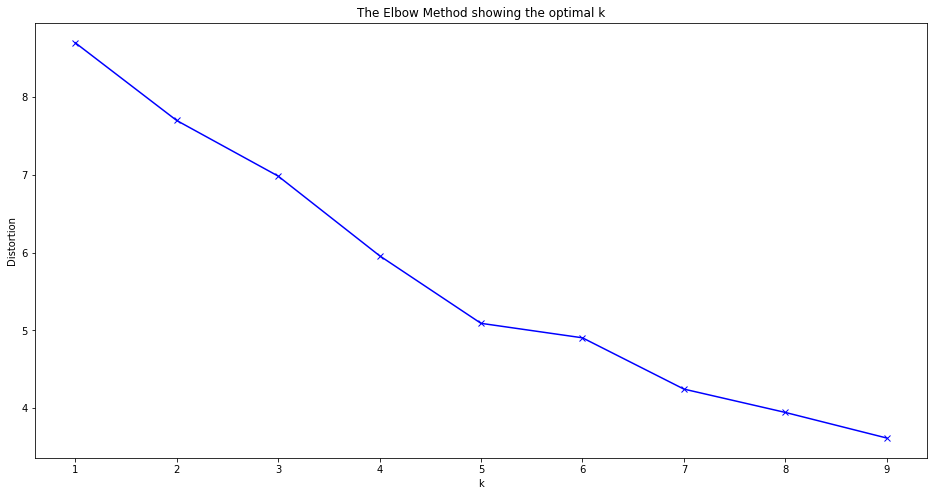

In [34]:
from matplotlib import pyplot as plt

plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

**Actually, this elbow plot is horrible, so I will just guess that I have to make 5 clusters. because after 5 the plot gets a little bit less steep**

In [35]:
# set number of clusters
kclusters = 5

Run k-means:

In [36]:
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(calgary_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 3, 1, 1, 1, 1, 1, 1, 1, 1])

In [37]:
kmeans.labels_.astype(int) 

array([1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       4, 2, 1, 1, 1, 1, 1, 1, 0, 1, 1])

Create a new dataframe that includes the cluster as well as the top 10 venues for each neighbourhood:

In [38]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

calgary_merged = df_calgary

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
calgary_merged = calgary_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

calgary_merged.head() # check the last columns!

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,T2A,Calgary,"Penbrooke Meadows, Marlborough",51.04968,-113.964320,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,T3A,Calgary,"Dalhousie, Edgemont, Hamptons, Hidden Valley",51.12606,-114.143158,1.0,Convenience Store,Asian Restaurant,Gas Station,Café,Yoga Studio,Falafel Restaurant,Cosmetics Shop,Deli / Bodega,Department Store,Dim Sum Restaurant
2,T2B,Calgary,"Forest Lawn, Dover, Erin Woods",51.03180,-113.978600,1.0,Convenience Store,Bar,Smoke Shop,Yoga Studio,Falafel Restaurant,Construction & Landscaping,Cosmetics Shop,Deli / Bodega,Department Store,Dim Sum Restaurant
3,T3B,Calgary,"Montgomery, Bowness, Silver Springs, Greenwood",51.08090,-114.161600,1.0,Coffee Shop,Bank,Food Court,Scenic Lookout,Electronics Store,Construction & Landscaping,Convenience Store,Cosmetics Shop,Deli / Bodega,Department Store
4,T2C,Calgary,"Lynnwood Ridge, Ogden, Foothills Industrial, G...",50.98780,-114.000100,1.0,Clothing Store,Convenience Store,Pizza Place,Diner,Yoga Studio,Comedy Club,Construction & Landscaping,Cosmetics Shop,Deli / Bodega,Department Store


**Visualize the results!:**

In [39]:
# displaying the datatypes 
display(calgary_merged.dtypes)

calgary_merged = calgary_merged.fillna(0)
  
# converting 'Weight' from float to int 
calgary_merged['Cluster Labels'] = calgary_merged['Cluster Labels'].astype(int) 
  
# displaying the datatypes 
#display(toronto_merged.dtypes) 

Postal Code                object
Borough                    object
Neighborhood               object
Latitude                  float64
Longitude                 float64
Cluster Labels            float64
1st Most Common Venue      object
2nd Most Common Venue      object
3rd Most Common Venue      object
4th Most Common Venue      object
5th Most Common Venue      object
6th Most Common Venue      object
7th Most Common Venue      object
8th Most Common Venue      object
9th Most Common Venue      object
10th Most Common Venue     object
dtype: object

In [40]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(
        calgary_merged['Latitude'], 
        calgary_merged['Longitude'], 
        calgary_merged['Neighborhood'], 
        calgary_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Examine the clusters

In [41]:
df1 = calgary_merged.loc[calgary_merged['Cluster Labels'] == 0, calgary_merged.columns[[1] + list(range(5, calgary_merged.shape[1]))]]
df1

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Calgary,0,0,0,0,0,0,0,0,0,0,0
23,Calgary,0,Convenience Store,Yoga Studio,Falafel Restaurant,Construction & Landscaping,Cosmetics Shop,Deli / Bodega,Department Store,Dim Sum Restaurant,Diner,Discount Store


In [42]:
df2 = calgary_merged.loc[calgary_merged['Cluster Labels'] == 1, calgary_merged.columns[[1] + list(range(5, calgary_merged.shape[1]))]]
df2

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Calgary,1,Convenience Store,Asian Restaurant,Gas Station,Café,Yoga Studio,Falafel Restaurant,Cosmetics Shop,Deli / Bodega,Department Store,Dim Sum Restaurant
2,Calgary,1,Convenience Store,Bar,Smoke Shop,Yoga Studio,Falafel Restaurant,Construction & Landscaping,Cosmetics Shop,Deli / Bodega,Department Store,Dim Sum Restaurant
3,Calgary,1,Coffee Shop,Bank,Food Court,Scenic Lookout,Electronics Store,Construction & Landscaping,Convenience Store,Cosmetics Shop,Deli / Bodega,Department Store
4,Calgary,1,Clothing Store,Convenience Store,Pizza Place,Diner,Yoga Studio,Comedy Club,Construction & Landscaping,Cosmetics Shop,Deli / Bodega,Department Store
5,Calgary,1,Sandwich Place,Fast Food Restaurant,Indian Restaurant,Pub,Mexican Restaurant,Fried Chicken Joint,Spa,Pizza Place,Candy Store,Thai Restaurant
6,Calgary,1,Fast Food Restaurant,Vietnamese Restaurant,Bank,Chinese Restaurant,Convenience Store,Noodle House,Dim Sum Restaurant,Indian Restaurant,Pharmacy,Restaurant
7,Calgary,1,Coffee Shop,Construction & Landscaping,Wine Shop,Vietnamese Restaurant,Asian Restaurant,Convenience Store,Cosmetics Shop,Deli / Bodega,Department Store,Dim Sum Restaurant
8,Calgary,1,Coffee Shop,Hotel,Pub,Performing Arts Venue,Theater,Cocktail Bar,Restaurant,Asian Restaurant,New American Restaurant,Italian Restaurant
9,Calgary,1,Pizza Place,Pub,Yoga Studio,Comedy Club,Construction & Landscaping,Convenience Store,Cosmetics Shop,Deli / Bodega,Department Store,Dim Sum Restaurant
11,Calgary,1,Vietnamese Restaurant,Convenience Store,Gas Station,Bar,Pizza Place,Yoga Studio,Dim Sum Restaurant,Donut Shop,Dog Run,Discount Store


In [43]:
df3 = calgary_merged.loc[calgary_merged['Cluster Labels'] == 2, calgary_merged.columns[[1] + list(range(5, calgary_merged.shape[1]))]]
df3

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
25,Calgary,2,Flea Market,Yoga Studio,Falafel Restaurant,Construction & Landscaping,Convenience Store,Cosmetics Shop,Deli / Bodega,Department Store,Dim Sum Restaurant,Diner


In [44]:
df4 = calgary_merged.loc[calgary_merged['Cluster Labels'] == 3, calgary_merged.columns[[1] + list(range(5, calgary_merged.shape[1]))]]
df4

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
16,Calgary,3,Electronics Store,Yoga Studio,Falafel Restaurant,Construction & Landscaping,Convenience Store,Cosmetics Shop,Deli / Bodega,Department Store,Dim Sum Restaurant,Diner


In [45]:
df5 = calgary_merged.loc[calgary_merged['Cluster Labels'] == 4, calgary_merged.columns[[1] + list(range(5, calgary_merged.shape[1]))]]
df5

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
10,Calgary,4,American Restaurant,Bowling Alley,Fast Food Restaurant,Convenience Store,Cosmetics Shop,Deli / Bodega,Department Store,Dim Sum Restaurant,Diner,Discount Store
21,Calgary,4,American Restaurant,Hotel,Falafel Restaurant,Construction & Landscaping,Convenience Store,Cosmetics Shop,Deli / Bodega,Department Store,Dim Sum Restaurant,Diner


Based on the clusters we see that cluster 1, 3 and 4 already have yoga studio as the 2nd most common venue. This makes us think that the better neighborhoods to start a yoga studie lie in cluster 2 and 5. Since the wish of our customer is to start a yoga studio in a neighborhood that does not already have a lot of other sports facilities, we would recommend to start a yoga studio in one of the two neighborhoods in cluster 5 (Northeast Calgary or Highfield), given that in the second cluster 10 out of 33 neighborhoods have yoga studios as well as that an additional 2 have a gym in the top 10 venues. 

## Now let's visualize the division of yoga studios in Calgary

In [46]:
search_query = 'Yoga'
radius = 500000000 #again set this very high number to incorporate all yoga studios

In [47]:
url2 = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude,ACCESS_TOKEN, VERSION, search_query, radius, LIMIT)
url2

'https://api.foursquare.com/v2/venues/search?client_id=D1UF1ORKKDYML4KS4JVLZ0BWDVZ2RY4CAOVJHZICIVAY2CCF&client_secret=L1EA15VVOMW33CCJZB2YNJNJOQXWHYR2NZAZ4H2PBUVUZQTG&ll=51.0534234,-114.0625892&oauth_token=H0YXC1VODECFZBJIISXHMYLBPFDRNZI3LV5FLKZJRJ5ACH03&v=20180605&query=Yoga&radius=500000000&limit=100'

In [48]:
results = requests.get(url2).json()
results

{'meta': {'code': 200, 'requestId': '6016d0b3b05314441f958898'},
 'notifications': [{'type': 'notificationTray', 'item': {'unreadCount': 0}}],
 'response': {'venues': [{'id': '4f10a2e6e4b019e990499987',
    'name': 'Samadhi Yoga Wellness Centre',
    'location': {'address': '458 8 Street SW',
     'crossStreet': '5 Avenue SW',
     'lat': 51.04918059732666,
     'lng': -114.08035421240902,
     'labeledLatLngs': [{'label': 'display',
       'lat': 51.04918059732666,
       'lng': -114.08035421240902}],
     'distance': 1329,
     'postalCode': 'T2P 0C4',
     'cc': 'CA',
     'city': 'Calgary',
     'state': 'AB',
     'country': 'Canada',
     'formattedAddress': ['458 8 Street SW (5 Avenue SW)',
      'Calgary AB T2P 0C4',
      'Canada']},
    'categories': [{'id': '52f2ab2ebcbc57f1066b8b3c',
      'name': 'Massage Studio',
      'pluralName': 'Massage Studios',
      'shortName': 'Massage Studio',
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/spa_',
       

In [49]:
# assign relevant part of JSON to venues
venues = results['response']['venues']

# tranform venues into a dataframe
dataframe = json_normalize(venues)
dataframe.head()

<ipython-input-49-5acf500bf9ad>:5: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  dataframe = json_normalize(venues)


,id,name,categories,referralId,hasPerk,location.address,location.crossStreet,location.lat,location.lng,location.labeledLatLngs,location.distance,location.postalCode,location.cc,location.city,location.state,location.country,location.formattedAddress,location.neighborhood,venuePage.id
0,4f10a2e6e4b019e990499987,Samadhi Yoga Wellness Centre,"[{'id': '52f2ab2ebcbc57f1066b8b3c', 'name': 'M...",v-1612107955,False,458 8 Street SW,5 Avenue SW,51.049181,-114.080354,"[{'label': 'display', 'lat': 51.04918059732666...",1329,T2P 0C4,CA,Calgary,AB,Canada,"[458 8 Street SW (5 Avenue SW), Calgary AB T2P...",NaN,NaN
1,4bb4178b49bdc9b6528c0c10,Yoga Santosha,"[{'id': '4bf58dd8d48988d102941735', 'name': 'Y...",v-1612107955,False,821 14 Street NW,NaN,51.059283,-114.094880,"[{'label': 'display', 'lat': 51.05928317021451...",2351,T2N 2A4,CA,Calgary,AB,Canada,"[821 14 Street NW, Calgary AB T2N 2A4, Canada]",Hillhurst,NaN
2,51412a3de4b054a20d4cca8e,The Yoga Studio (Calgary),"[{'id': '4bf58dd8d48988d102941735', 'name': 'Y...",v-1612107955,False,"#110, 1330 15 Ave. S.W.",Wellington Square: 14th Street & 15th Avenue S.W.,51.039671,-114.092934,"[{'label': 'display', 'lat': 51.03967149625019...",2617,T3C 3N7,CA,Calgary,AB,Canada,"[#110, 1330 15 Ave. S.W. (Wellington Square: 1...",NaN,NaN
3,4dd846437d8b3226640561db,Fifth Avenue Yoga,"[{'id': '4bf58dd8d48988d102941735', 'name': 'Y...",v-1612107955,False,NaN,NaN,51.048630,-114.062908,"[{'label': 'display', 'lat': 51.04863, 'lng': ...",534,NaN,CA,Calgary,AB,Canada,"[Calgary AB, Canada]",NaN,NaN
4,4d718190311f6ea8664fcdea,Yoga Mandala,"[{'id': '4bf58dd8d48988d102941735', 'name': 'Y...",v-1612107955,False,NaN,NaN,51.057613,-114.052788,"[{'label': 'display', 'lat': 51.057613, 'lng':...",829,NaN,CA,NaN,NaN,Canada,[Canada],NaN,NaN


In [50]:
# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
dataframe_filtered = dataframe.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]

dataframe_filtered

,name,categories,address,crossStreet,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,neighborhood,id
0,Samadhi Yoga Wellness Centre,Massage Studio,458 8 Street SW,5 Avenue SW,51.049181,-114.080354,"[{'label': 'display', 'lat': 51.04918059732666...",1329,T2P 0C4,CA,Calgary,AB,Canada,"[458 8 Street SW (5 Avenue SW), Calgary AB T2P...",NaN,4f10a2e6e4b019e990499987
1,Yoga Santosha,Yoga Studio,821 14 Street NW,NaN,51.059283,-114.094880,"[{'label': 'display', 'lat': 51.05928317021451...",2351,T2N 2A4,CA,Calgary,AB,Canada,"[821 14 Street NW, Calgary AB T2N 2A4, Canada]",Hillhurst,4bb4178b49bdc9b6528c0c10
2,The Yoga Studio (Calgary),Yoga Studio,"#110, 1330 15 Ave. S.W.",Wellington Square: 14th Street & 15th Avenue S.W.,51.039671,-114.092934,"[{'label': 'display', 'lat': 51.03967149625019...",2617,T3C 3N7,CA,Calgary,AB,Canada,"[#110, 1330 15 Ave. S.W. (Wellington Square: 1...",NaN,51412a3de4b054a20d4cca8e
3,Fifth Avenue Yoga,Yoga Studio,NaN,NaN,51.048630,-114.062908,"[{'label': 'display', 'lat': 51.04863, 'lng': ...",534,NaN,CA,Calgary,AB,Canada,"[Calgary AB, Canada]",NaN,4dd846437d8b3226640561db
4,Yoga Mandala,Yoga Studio,NaN,NaN,51.057613,-114.052788,"[{'label': 'display', 'lat': 51.057613, 'lng':...",829,NaN,CA,NaN,NaN,Canada,[Canada],NaN,4d718190311f6ea8664fcdea
5,Yoga MCC,Yoga Studio,NaN,NaN,51.024652,-114.105572,"[{'label': 'display', 'lat': 51.0246521376727,...",4394,NaN,CA,NaN,NaN,Canada,[Canada],NaN,518c4aa0498e41eec04ad523
6,Yoga and Beyond Centre Street,Yoga Studio,"200, 1609 Centre Street NW",NaN,51.065989,-114.063064,"[{'label': 'display', 'lat': 51.06598928745742...",1399,T2E 2S2,CA,Calgary,AB,Canada,"[200, 1609 Centre Street NW, Calgary AB T2E 2S...",NaN,541ca5dd498e141e88fc2a27
7,Unify Yoga,Yoga Studio,805 1st St. SW Unit 2,NaN,51.045657,-114.065522,"[{'label': 'display', 'lat': 51.04565749926963...",888,T2P 7N2,CA,Calgary,AB,Canada,"[805 1st St. SW Unit 2, Calgary AB T2P 7N2, Ca...",NaN,525852c111d26006c4b9cc77
8,Yoga Passage,Yoga Studio,524-11 Avenue South West,NaN,51.042799,-114.073123,"[{'label': 'display', 'lat': 51.04279854859828...",1393,T2R 0C8,CA,Calgary,AB,Canada,"[524-11 Avenue South West, Calgary AB T2R 0C8,...",NaN,4b0586f1f964a5203c7722e3
9,Be Love Yoga,Yoga Studio,105 1409 Edmonton Trail NE,NaN,51.065084,-114.056801,"[{'label': 'display', 'lat': 51.065084, 'lng':...",1359,T2E 3K8,CA,Calgary,AB,Canada,"[105 1409 Edmonton Trail NE, Calgary AB T2E 3K...",NaN,4f496bffe4b076e6e095500e


In [51]:
dataframe_filtered.name

0                          Samadhi Yoga Wellness Centre
1                                         Yoga Santosha
2                             The Yoga Studio (Calgary)
3                                     Fifth Avenue Yoga
4                                          Yoga Mandala
5                                              Yoga MCC
6                         Yoga and Beyond Centre Street
7                                            Unify Yoga
8                                          Yoga Passage
9                                          Be Love Yoga
10                       Yoga Centre of Calgary Society
11         J-Yoga: Calgary's Most Exclusive Yoga Studio
12                                        Yoga Santosha
13                         Rejuve! Infrared yoga studio
14         Brahma Kumaris Meditation Centre - Raja Yoga
15                                    Yoga Studio South
16                                My Yoga Calgary (MYC)
17                                             S

In [52]:
venues_map = folium.Map(location=[latitude, longitude], zoom_start=13) # generate map centred around the Conrad Hotel

# add a red circle marker to represent the coordinates of Calgary
folium.CircleMarker(
    [latitude, longitude],
    radius=10,
    color='red',
    popup='Mid of Calgary',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(venues_map)

# add the yoga studios as blue circle markers
for lat, lng, label in zip(dataframe_filtered.lat, dataframe_filtered.lng, dataframe_filtered.categories):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(venues_map)

# display map
venues_map

### Now, we see that most yoga studios are centred in the mid of Calgary, and no yoga studios are located in the north of Calgary. 

Actually, this perfectly matches our previous conclusion that Northeast Calgary would be the best spot to start a yoga studio!